In [1]:
import sys, os
import ROOT as R

Welcome to JupyROOT 6.16/00


In [2]:
%env ANALYSISHOME=/home/mo/Analysis/HMuMu

env: ANALYSISHOME=/home/mo/Analysis/HMuMu


In [3]:
sys.path.append(os.path.join(os.environ["ANALYSISHOME"], "Configuration", "higgs"))                     
 

In [4]:
# R.gStyle.SetPalette(R.kCMYK)

In [5]:
import Samples as S
mc_samples = S.mc_background_2017
mc_samples.update(S.mc_signal_2017)
root_dic = []
lumi = 41860

In [6]:
for file in os.listdir("histoFiles/"):
    if file.endswith(".root") and not file.startswith("all"):
        nickname = file.replace(".root","")
        dic = {}
        dic["fullname"] = file
        for k,v in mc_samples.items():
            if nickname in k:
                dic["isSignal"] = v.isSignal                    
        f = R.TFile.Open("histoFiles/"+file)
        nEvents = f.Get("dimuon_mass").GetMaximum()
        dic["wEvents"] = nEvents
        dic["TFile"] = f
        root_dic.append((nickname,dic))

In [7]:
root_dic = sorted(root_dic, key= lambda el: el[1]['wEvents'])

In [8]:
data = R.TFile.Open("histoFiles/allData.root")

Error in <TFile::TFile>: file histoFiles/allData.root does not exist


In [9]:
bcColors = [40,30,41,42,43,35,46,47,38,28,29]
sigColors = [2,3,4,6,8,9]

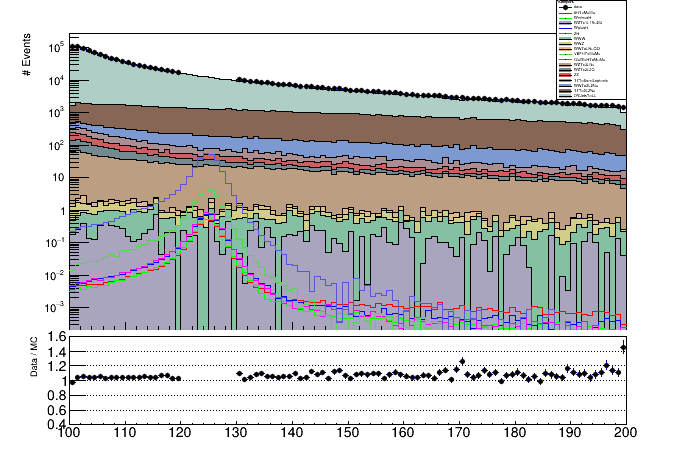

In [10]:
# def plot_variable(variable, logy):
variable = "dimuon_mass"
logy = True
canvas = R.TCanvas("c1","c1")
canvas.cd()
pad1 = R.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0)
pad1.Draw()
canvas.cd()
pad2 = R.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
pad2.Draw()
pad2.cd()
pad2.SetTopMargin(0.05)
pad2.SetBottomMargin(0.2)
pad2.SetGridy()
pad1.cd()

bkgStack = R.THStack("bkgStack","")
sigStack = R.THStack("sigStack","")
allStack = R.THStack("allStack","")
hdata = data.Get(variable)

leg = R.TLegend(0.8, 0.7, .9, 1.)
leg.SetHeader("Samples")
leg.AddEntry(hdata, "data")

sigHistos = []
i = 0
j = 0
for v in root_dic:
    if not v[1]["isSignal"]:
        histo = v[1]["TFile"].Get(variable)
        histo.SetLineWidth(1)
        histo.SetLineColor(R.kBlack)
        histo.SetTitle(v[0].split("_")[0])
        histo.SetFillColor(bcColors[(i%len(bcColors))])
        # multiply by lumi!
        histo.Scale(lumi)
        leg.AddEntry(histo,v[0].split("_")[0])
        bkgStack.Add(histo)
        allStack.Add(histo)
#             bgsum.Add(histo)
        i+=1
    if v[1]["isSignal"]:
        histo = v[1]["TFile"].Get(variable)
        histo.SetLineColor(sigColors[(j%len(sigColors))])
        histo.Scale(lumi)
        leg.AddEntry(histo,v[0].split("_")[0])
        sigHistos.append(histo)
        sigStack.Add(histo)
        allStack.Add(histo)
        j+=1

if variable == "dimuon_mass":
    for i in range(hdata.GetNbinsX()):
        if hdata.GetBinCenter(i+1)>120 and hdata.GetBinCenter(i+1)<130:
            hdata.SetBinContent(i+1, 0)

hdata.SetMarkerStyle(20)
hdata.SetMarkerSize(.5)
if logy:
    pad1.SetLogy()
    bkgStack.SetMinimum(.001)
    
hdata.SetStats(R.kFALSE)
hdata.GetXaxis().SetLabelSize(0)
bkgStack.Draw("hist")
for h in sigHistos:
    h.Draw("hist same")
hdata.Draw("same p")
bkgStack.GetXaxis().SetTitle(variable)
bkgStack.GetYaxis().SetTitle("# Events")
leg.Draw()
R.gPad.Modified()

pad2.cd()
hratio = hdata.Clone()
hratio.SetTitle("")
hratio.GetYaxis().SetTitle("Data / MC")
hratio.GetXaxis().SetTitle(variable)
hratio.GetYaxis().SetNdivisions(6, R.kFALSE)
hratio.GetYaxis().SetTitleSize(10)
hratio.GetYaxis().SetTitleFont(43)
hratio.GetYaxis().SetTitleOffset(1.55)
hratio.GetYaxis().SetLabelFont(43)
hratio.GetYaxis().SetLabelSize(15)
hratio.GetXaxis().SetTitleSize(20)
hratio.GetXaxis().SetTitleFont(43)
hratio.GetXaxis().SetTitleOffset(4)
hratio.GetXaxis().SetLabelFont(43)
hratio.GetXaxis().SetLabelSize(15)
hratio.Divide(allStack.GetStack().Last())
hratio.SetStats(R.kFALSE)
hratio.Draw("ep")
hratio.SetMaximum(1.6)
hratio.SetMinimum(0.4)
hratio.SetMarkerStyle(20)
hratio.SetMarkerSize(0.5)
R.gPad.Modified()
canvas.Draw()

# canvas.SaveAs("plots/"+variable+".pdf")

In [11]:
from math import sqrt

In [12]:
jet_mass_dimuon_dic = {}
for jetMass in range(0,1010,10):
    bkg_stack = R.THStack("bkg{}".format(jetMass),"")
    sig_stack = R.THStack("sig{}".format(jetMass),"")
    histo_name = 'dimuon_mass_jet_{}'.format(jetMass)
    for v in root_dic:
        histo = v[1]["TFile"].Get(histo_name)
        histo.Scale(lumi)
        if v[1]["isSignal"]:
            sig_stack.Add(histo)
        else:
            bkg_stack.Add(histo)
    jet_mass_dimuon_dic[jetMass] = (sig_stack,bkg_stack)

In [13]:
x = []
y = []
binlow = 41
binhigh = 61
for jetMass, stacks in jet_mass_dimuon_dic.items():
    x.append(jetMass)
    sigSum = stacks[0].GetStack().Last()
    bkgSum = stacks[1].GetStack().Last()
    sens = 0
    for ibin in range(binlow,binhigh+1):
        sigi = sigSum.GetBinContent(ibin)
        bigi = bkgSum.GetBinContent(ibin)
        sensi = sigi**2/bigi if bigi else 0
        sens += sensi
    yy = sqrt(sens) if sens > 0 else 0
    y.append(yy)

In [14]:
from array import array
ax = array('f')
ay = array('f')
n = len(x)
for i in range(n):
    ax.append(x[i])
    ay.append(y[i])

Info in <TCanvas::Print>: pdf file plots/dijet_mass_scan_lower.pdf has been created


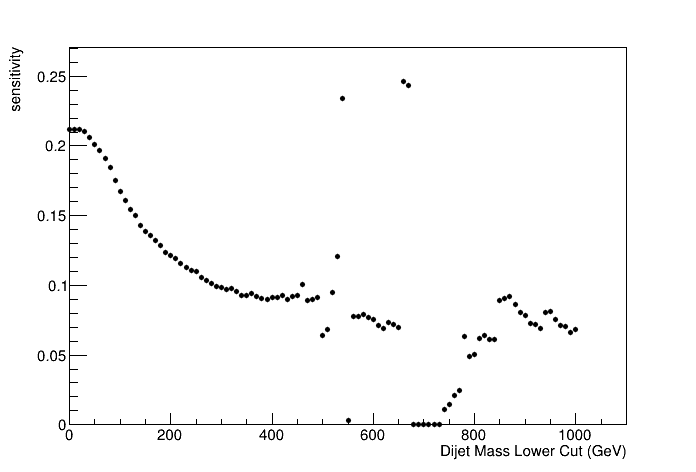

In [15]:
c1 = R.TCanvas('c4','c4')
gr = R.TGraph(n,ax,ay)
gr.SetMarkerStyle(8)
gr.SetMarkerSize(.5)
gr.SetTitle(";Dijet Mass Lower Cut (GeV); sensitivity")
gr.Draw('APE')
c1.Draw()
c1.SaveAs('plots/dijet_mass_scan_lower.pdf')

In [16]:
jet_mass_dimuon_dic[0][1].GetMaximum()


1288.9482421875

In [17]:
jet_mass_dimuon_r_dic = {}
for jetMass in range(0,1010,10):
    bkg_stack = R.THStack("bkg_r{}".format(jetMass),"")
    sig_stack = R.THStack("sig_r{}".format(jetMass),"")
    histo_name = 'dimuon_mass_jet_r_{}'.format(jetMass)
    for v in root_dic:
        histo = v[1]["TFile"].Get(histo_name)
        histo.Scale(lumi)
        if v[1]["isSignal"]:
            sig_stack.Add(histo)
        else:
            bkg_stack.Add(histo)
    jet_mass_dimuon_r_dic[jetMass] = (sig_stack,bkg_stack)

In [18]:
xr = []
yr = []
binlow = 41
binhigh = 61
for jetMass, stacks in jet_mass_dimuon_r_dic.items():
    xr.append(jetMass)
    sigSum = stacks[0].GetStack().Last()
    bkgSum = stacks[1].GetStack().Last()
    for ibin in range(binlow,binhigh+1):
        sigi = sigSum.GetBinContent(ibin)
        bigi = bkgSum.GetBinContent(ibin)
        sensi = sigi**2/bigi if bigi else 0
        sens += sensi
    yy = sqrt(sens) if sens > 0 else 0
    yr.append(yy)

In [19]:
from array import array
axr = array('f')
ayr = array('f')
nr = len(xr)
for i in range(n):
    axr.append(xr[i])
    ayr.append(yr[i])

Info in <TCanvas::Print>: pdf file plots/dijet_mass_scan_upper.pdf has been created


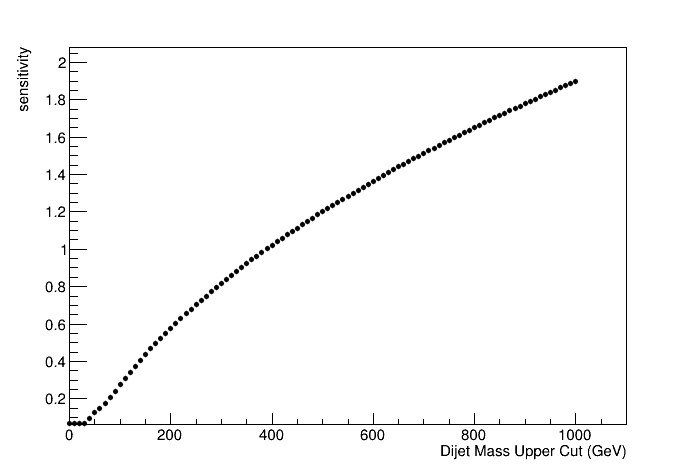

In [20]:
c2 = R.TCanvas('c5','c5')
grr = R.TGraph(nr,axr,ayr)
grr.SetMarkerStyle(8)
grr.SetMarkerSize(.5)
grr.SetTitle(";Dijet Mass Upper Cut (GeV); sensitivity")
grr.Draw('APE')
c2.Draw()
c2.SaveAs('plots/dijet_mass_scan_upper.pdf')

In [21]:
# c7 = R.TCanvas("c7","c7")
# sig = sigStack.GetStack().Last()
# # sig.SetMarkerStyle(8)
# # sig.SetMarkerSize(.5)
# # sig.SetStats(R.kTRUE)
# R.gStyle.SetOptStat("")
# R.gStyle.SetOptFit(1)
# fit = R.TF1("fit","crystalball")
# # print(fit.GetNumberFreeParameters())
# fit.SetParameters(1.5,125,1.5,5,5);
# sig.Fit(fit)
# sig.Draw("")
# # c7.SetLogy()
# sig.SetMinimum(.001)
# c7.Draw()
# c7.SaveAs("plots/sig_fit.pdf")
# # sig

In [22]:
# canvas = R.TCanvas("c2","c2")
# sigsum = sig_stack.GetStack().Last()
# # sigsum = sigStack.GetStack().Last()  
# # bkgsum = bkgStack.GetStack().Last()
# # bkgsum.SetMinimum(.001)
# # bkgsum.SetStats(R.kFALSE)
# # sigsum.SetStats(R.kFALSE)
# # bkgsum.Draw("hist")
# fit = R.TF1("fit","crystalball")
# # print(fit.GetNumberFreeParameters())
# fit.SetParameters(1.5,125,1.5,5,5);
# sigsum.Fit(fit)
# sigsum.Draw("same")
# # fit.GetParamters()
# fit.Draw("same")
# # canvas.SetLogy()
# canvas.Draw()

In [23]:
# canvas2 = R.TCanvas("c3","c3")
# test = R.TF1("test","crystalball")
# test.SetParameters(60,125,5,1,1)
# # test.Draw()
# test.SetRange(100,150)
# test.Draw()
# # canvas2.SetLogy()
# canvas2.Draw()